# COVID19 severe (hospitalized) cases in Brazil: ML logistic regression

Here, publicly available data for hospitalized cases in Brazil is used to perform a retrospective cross-sectional observational study.

It means that I want to infer the paramaters driving the outcome from data gathered from hospitals.
The data has been downloaded, selected and preprocessed before the steps described in this notebook.

The aim is to compare different variants and infer what parameters are driving the severity and the outcome. This will provide answers to the following questions:
<ol>
    <li> Can we predict the outcome?</li>
    <li> If yes, what are the parameters influencing the outcome?</li>
</ol>
<br>
I study only the main outcome: cured/death.

This is applied to four different periods of time when four different variants where dominant (>=80% of samples analyzed were corresponding to the variant of interest, source: GISAID database):
- Delta
- Omicron BA.1
- Omicron BA.2
- Omicron BA.4/BA.5

Specifically, in this notebook, **I show the results of Machine Learning logistic regression on the main outcome**.

> **Data source**: all the data has been taken from the Brazilian Ministry of Health https://opendatasus.saude.gov.br/organization/ministerio-da-saude
>
>It requires translation from Portuguese to English

> **<font size=5 color='red'>IMPORTANT DISCLAIMER</font>**: in this work, we extract data about **HOSPITALIZED** patients, by definition people already severely affected by the disease, hence a strongly biased sample unfit to get the whole picture about all the aspects of COVID19

In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Read data

In [2]:
comorb_list = ['cardiovascular_disease','hematologic_disease','down_syndrom','liver_disease','comorb_asthma','diabetes',
               'neurological_disease','chronic_lung_disease','weaken_immune_system','renal_disease','obesity','puerperal',
               'other_comorbidities']
symptom_list = ['abdominal_pain','altered_smell_taste','anxiety','asthma','asymptomatic','back_pain','blocked_nose',
                'blurred_vision','body_aches','chest_pain','chills_or_shivers','cyanosis','delirium','diarrhoea',
                'discomfort','dizzy_light_headed','eye_soreness','fatigue_weakness','fever','gastrointestinal_symptoms',
                'headache','insomnia','loss_of_appetite','low_o2_sat','myalgia','nausea','other','other_respiratory',
                'other_skin','persistent_cough','retro_orbital_pain','runny_nose','seizures','shortness_of_breath',
                'skin_lesions','sneezing','sore_throat','unusual_joint_pains']
variants_name = ['Delta','BA.1.X','BA.2.X','BA.4/5.X']

In [3]:
df_encoded = pd.read_parquet('df_ML.pq')

In [4]:
state_list = df_encoded.columns[df_encoded.columns.str.contains('state')].tolist()
variant_list = df_encoded.columns[df_encoded.columns.str.contains('variant')].tolist()
ethnicity_list = df_encoded.columns[df_encoded.columns.str.contains('ethnicity')].tolist()

# Machine Learning: Multivariate Logistic Regression

## Features selection for model

I exclude icu admission and invasive ventilation from parameters since they are strongly correlated with the final outcome (as logically expected)

I drop also noninvasive ventilation and length of stay: features created while hospitalized

I work on reducing the number of parameters going into the training.

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from statsmodels.stats.outliers_influence import variance_inflation_factor

I arbitrarly set the minimum number of parameters to go into the fitting to 15.

In [6]:
list_features = []
for variant in variants_name:
    print(variant)
    df_variant = df_encoded[df_encoded['variant_'+variant]==1].drop(columns=['age_group','ventilation_invasive','icu_adm','pregnancy','puerperal','ventilation_noninvasive','length_stay']).drop(columns=variant_list)
    df_variant_filled = df_variant.dropna(axis=0)
    X, y = df_variant_filled.drop(['outcome'],1), df_variant_filled.outcome
    scaler = MinMaxScaler()
    X[['age','nb_comorbidities','delay_lastdose_onset','length_delay','nb_vaccine_dose']] = scaler.fit_transform(X[['age','nb_comorbidities','delay_lastdose_onset','length_delay','nb_vaccine_dose']])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    logreg = LogisticRegression(solver='newton-cholesky')
    selector = RFECV(logreg,step=1,min_features_to_select=15)
    check_convergence = 0
    init_df = 0
    while (check_convergence==0):
        if init_df == 0:
            X_loop = X_train.copy()
            init_df = 1
        else:
            X_loop = X_train[feature_order[feature_order.ranking==1].feature]
        selector = selector.fit(X_loop,y_train)
        score = selector.score(X_test[X_loop.columns],y_test)
        print("Test score:{:.3f}".format(score),' ',end="")
        feature_order = pd.DataFrame()
        feature_order['feature'] = X_loop.columns
        feature_order['selected'] = selector.support_
        feature_order['ranking'] = selector.ranking_
        print('nb of features:',len(X_loop.columns))
        if len(X_loop.columns) == len(X_train[feature_order[feature_order.ranking==1].feature].columns):
            check_convergence = 1
            list_features.append(X_train[feature_order[feature_order.ranking==1].feature].columns.tolist())

Delta
Test score:0.709  nb of features: 89
Test score:0.708  nb of features: 51
Test score:0.702  nb of features: 47
Test score:0.703  nb of features: 39
Test score:0.703  nb of features: 38
BA.1.X
Test score:0.703  nb of features: 89
Test score:0.703  nb of features: 55
BA.2.X
Test score:0.765  nb of features: 89
Test score:0.763  nb of features: 17
Test score:0.763  nb of features: 15
BA.4/5.X
Test score:0.732  nb of features: 89
Test score:0.732  nb of features: 79
Test score:0.732  nb of features: 75
Test score:0.734  nb of features: 71
Test score:0.735  nb of features: 64
Test score:0.735  nb of features: 50
Test score:0.732  nb of features: 48
Test score:0.728  nb of features: 46
Test score:0.728  nb of features: 43


## Fit

In [7]:
list_param_toscale = ['age','nb_comorbidities','delay_lastdose_onset','length_delay','nb_vaccine_dose']
for variant in variants_name:
    print(variant)
    df_variant = df_encoded[df_encoded['variant_'+variant]==1].drop(columns=['age_group','ventilation_invasive','icu_adm','pregnancy','puerperal','ventilation_noninvasive','length_stay']).drop(columns=variant_list)
    param_variant = list_features[variants_name.index(variant)].copy()
    param_variant.append('outcome')
    df_variant = df_variant[param_variant]
    df_variant_filled = df_variant.dropna(axis=0)
    X, y = df_variant_filled.drop(['outcome'],1), df_variant_filled.outcome
    param_toscale = []
    for param in list_param_toscale:
        if param in df_variant_filled.columns:
                param_toscale.append(param)
    if len(param_toscale)>0:
        scaler = MinMaxScaler()
        X[param_toscale] = scaler.fit_transform(X[param_toscale])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    logm1 = sm.GLM(y_train,(sm.add_constant(X_train)),family = sm.families.Binomial())
#    logreg = LogisticRegression(solver='newton-cholesky')
    if variant == 'Delta':
        res_delta = logm1.fit()
    elif variant == 'BA.1.X':
        res_ba1x = logm1.fit()
    elif variant == 'BA.2.X':
        res_ba2x = logm1.fit()
    elif variant == 'BA.4/5.X':
        res_ba45x = logm1.fit()

Delta
BA.1.X
BA.2.X
BA.4/5.X


## Model evaluation

### Delta

In [8]:
for variant in ['Delta']:
    print(variant)
    df_variant = df_encoded[df_encoded['variant_'+variant]==1].drop(columns=['age_group','ventilation_invasive','icu_adm','pregnancy','puerperal','ventilation_noninvasive','length_stay']).drop(columns=variant_list)
    param_variant = list_features[variants_name.index(variant)].copy()
    param_variant.append('outcome')
    df_variant = df_variant[param_variant]
    df_variant_filled = df_variant.dropna(axis=0)
    X, y = df_variant_filled.drop(['outcome'],1), df_variant_filled.outcome
    param_toscale = []
    for param in list_param_toscale:
        if param in df_variant_filled.columns:
                param_toscale.append(param)
    if len(param_toscale)>0:
        scaler = MinMaxScaler()
        X[param_toscale] = scaler.fit_transform(X[param_toscale])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

Delta


#### Compare predicted outcome with observed outcome

In [9]:
y_train_pred = res_delta.predict(sm.add_constant(X_train))
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final['Predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x>0.5 else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,Predicted
0,1,0.511241,1
1,0,0.324666,0
2,0,0.026855,0
3,0,0.172495,0
4,0,0.232226,0


#### Confusion matrix

Visualize algorithm performance


|True Negative | False Positive|
|-|-|
|**False Negative** | **True Positive**|

In [10]:
#confusion matrix

from sklearn import metrics

confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted)
print(confusion)

[[5974  823]
 [2226 1242]]


<AxesSubplot:>

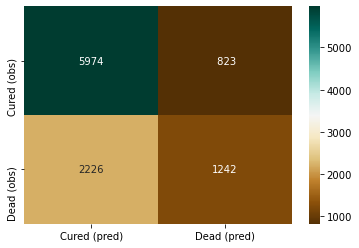

In [11]:
import seaborn as sns

df_cm = pd.DataFrame(confusion,index=['Cured (obs)','Dead (obs)'],columns=['Cured (pred)','Dead (pred)'])
sns.heatmap(df_cm,annot=True,fmt='4d',cmap='BrBG')

#### Accuracy

(TP+TN) / (TP+TN+FP+FN)

In [12]:
print(metrics.accuracy_score(y_train_pred_final.Converted,y_train_pred_final.Predicted))

0.7029712615684365


In [13]:
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]

In [14]:
#precision
print('Precision:',TP/(TP+FP))
#recall
print('Recall:',TP/(TP+FN))
#f-score
print('f-score:',((TP/(TP+FP))*(TP/(TP+FN)))/((TP/(TP+FP))+(TP/(TP+FN))))

Precision: 0.6014527845036319
Recall: 0.35813148788927335
f-score: 0.22447135369600577


As the algorithm is set, it predicts the outcome for the training set correcly 70% of the time

But the is data unbalanced: 66% of cured vs. 34% of dead in the training data.

Model predicts correctly death in only **36%** of the cases (recall).

#### Model optimization
#### ROC function

In [15]:
# ROC function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [16]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob, drop_intermediate = False )


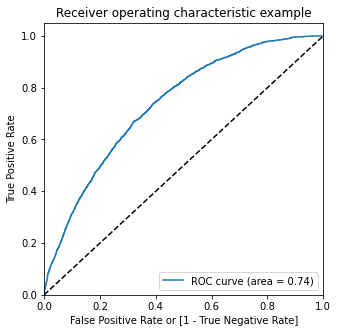

In [17]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

#### trade off: accuracy, specificity, sensitivity

In [18]:
numbers = [float(x)/10 for x in range(10)]
numbers = np.linspace(0,1,21)
for i in numbers:
    y_train_pred_final['%.2f'%i]= y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,Predicted,0.00,0.05,0.10,0.15,0.20,0.25,0.30,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
0,1,0.511241,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0.324666,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0.026855,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.172495,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.232226,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

num = np.linspace(0,1,21)
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final['%.2f'%i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

      prob  accuracy     sensi     speci
0.00  0.00  0.337847  1.000000  0.000000
0.05  0.05  0.377691  0.998270  0.061056
0.10  0.10  0.434291  0.985006  0.153303
0.15  0.15  0.495860  0.959054  0.259526
0.20  0.20  0.545835  0.914360  0.357805
0.25  0.25  0.595421  0.855825  0.462557
0.30  0.30  0.637604  0.777682  0.566132
0.35  0.35  0.666245  0.681949  0.658232
0.40  0.40  0.688456  0.581027  0.743269
0.45  0.45  0.701218  0.470877  0.818744
0.50  0.50  0.702971  0.358131  0.878917
0.55  0.55  0.698003  0.262687  0.920112
0.60  0.60  0.689722  0.176471  0.951596
0.65  0.65  0.685046  0.119666  0.973518
0.70  0.70  0.678324  0.071799  0.987789
0.75  0.75  0.671310  0.039216  0.993821
0.80  0.80  0.668290  0.022491  0.997793
0.85  0.85  0.665173  0.010381  0.999264
0.90  0.90  0.664004  0.005767  0.999853
0.95  0.95  0.662835  0.002307  0.999853
1.00  1.00  0.662153  0.000000  1.000000


<AxesSubplot:xlabel='prob'>

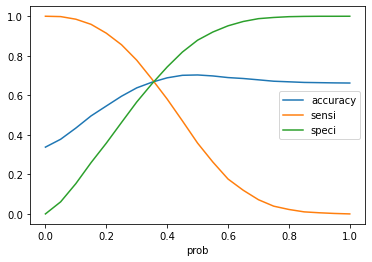

In [20]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

In [21]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map( lambda x: 1 if x > 0.35 else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,Predicted,0.00,0.05,0.10,0.15,0.20,0.25,0.30,...,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00,final_predicted
0,1,0.511241,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0.324666,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0.026855,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.172495,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.232226,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Evaluation model with new cut off

In [22]:
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.6662445202143205

[[4474 2323]
 [1103 2365]]


<AxesSubplot:>

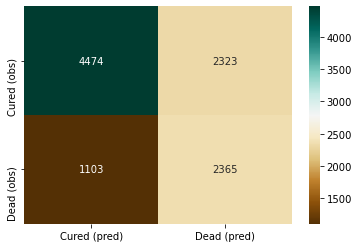

In [23]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
print(confusion2)
df_cm = pd.DataFrame(confusion2,index=['Cured (obs)','Dead (obs)'],columns=['Cured (pred)','Dead (pred)'])
sns.heatmap(df_cm,annot=True,fmt='4d',cmap='BrBG')

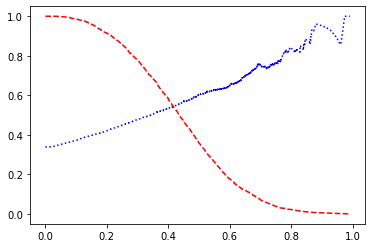

In [24]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)
plt.plot(thresholds, p[:-1], "b:")
plt.plot(thresholds, r[:-1], "r--")

cut off value near value where precision and recall intersect: keep model as it is

## Model prediction on test set

0.6543181818181818
[[1919 1054]
 [ 467  960]]
Precision: 0.4766633565044687
Recall: 0.6727400140154169
f-score: 0.2789886660854403


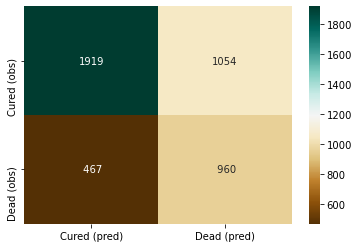

In [25]:
y_test_pred = res_delta.predict(sm.add_constant(X_test))
y_pred_1 = pd.DataFrame(y_test_pred)
y_test_df = pd.DataFrame(y_test)
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final= y_pred_final.rename(columns = {0 : 'Conversion_Prob'})
y_pred_final['final_predicted'] = y_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.35 else 0)
print(metrics.accuracy_score(y_pred_final['outcome'], y_pred_final.final_predicted))
confusion3 = metrics.confusion_matrix(y_pred_final['outcome'], y_pred_final.final_predicted )
print(confusion3)
df_cm = pd.DataFrame(confusion3,index=['Cured (obs)','Dead (obs)'],columns=['Cured (pred)','Dead (pred)'])
sns.heatmap(df_cm,annot=True,fmt='4d',cmap='BrBG')
TP = confusion3[1,1] 
TN = confusion3[0,0] 
FP = confusion3[0,1] 
FN = confusion3[1,0] 
#precision
print('Precision:',TP/(TP+FP))
#recall
print('Recall:',TP/(TP+FN))
#f-score
print('f-score:',((TP/(TP+FP))*(TP/(TP+FN)))/((TP/(TP+FP))+(TP/(TP+FN))))

# BA.1.X

## Fit and model evaluation

[[14585  2358]
 [ 5298  3460]]
0.7021127582584336
Precision: 0.5947060845651426
Recall: 0.39506736697876227
f-score: 0.2373765093304061


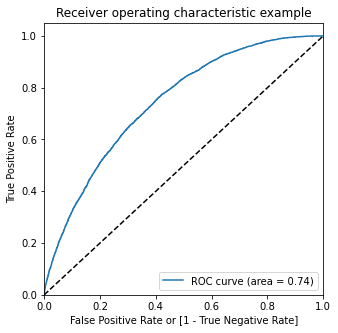

      prob  accuracy     sensi     speci
0.00  0.00  0.340765  1.000000  0.000000
0.05  0.05  0.391230  0.997374  0.077908
0.10  0.10  0.454924  0.984129  0.181373
0.15  0.15  0.508735  0.956040  0.277519
0.20  0.20  0.558811  0.915163  0.374609
0.25  0.25  0.600560  0.857730  0.467627
0.30  0.30  0.636668  0.787851  0.558520
0.35  0.35  0.664215  0.701187  0.645104
0.40  0.40  0.687755  0.609272  0.728324
0.45  0.45  0.701724  0.508564  0.801570
0.50  0.50  0.702113  0.395067  0.860827
0.55  0.55  0.701685  0.293560  0.912648
0.60  0.60  0.692891  0.196049  0.949714
0.65  0.65  0.682619  0.119205  0.973854
0.70  0.70  0.673943  0.066568  0.987901
0.75  0.75  0.667756  0.033113  0.995809
0.80  0.80  0.664021  0.017127  0.998406
0.85  0.85  0.661531  0.007422  0.999646
0.90  0.90  0.660363  0.003311  1.000000
0.95  0.95  0.659780  0.001599  1.000000
1.00  1.00  0.659235  0.000000  1.000000


<AxesSubplot:xlabel='prob'>

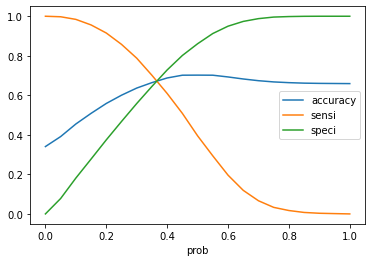

In [26]:
for variant in ['BA.1.X']:
    df_variant = df_encoded[df_encoded['variant_'+variant]==1].drop(columns=['age_group','ventilation_invasive','icu_adm','pregnancy','puerperal','ventilation_noninvasive','length_stay']).drop(columns=variant_list)
    param_variant = list_features[variants_name.index(variant)].copy()
    param_variant.append('outcome')
    df_variant = df_variant[param_variant]
    df_variant_filled = df_variant.dropna(axis=0)
    X, y = df_variant_filled.drop(['outcome'],1), df_variant_filled.outcome
    param_toscale = []
    for param in list_param_toscale:
        if param in df_variant_filled.columns:
                param_toscale.append(param)
    if len(param_toscale)>0:
        scaler = MinMaxScaler()
        X[param_toscale] = scaler.fit_transform(X[param_toscale])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
y_train_pred = res_ba1x.predict(sm.add_constant(X_train))
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final['Predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x>0.5 else 0)
#confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted)
print(confusion)
print(metrics.accuracy_score(y_train_pred_final.Converted,y_train_pred_final.Predicted))
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]
#precision
print('Precision:',TP/(TP+FP))
#recall
print('Recall:',TP/(TP+FN))
#f-score
print('f-score:',((TP/(TP+FP))*(TP/(TP+FN)))/((TP/(TP+FP))+(TP/(TP+FN))))
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)
numbers = [float(x)/10 for x in range(10)]
numbers = np.linspace(0,1,21)
for i in numbers:
    y_train_pred_final['%.2f'%i]= y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
num = np.linspace(0,1,21)
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final['%.2f'%i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

[[10930  6013]
 [ 2617  6141]]


<AxesSubplot:>

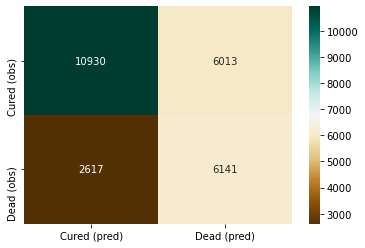

In [27]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map( lambda x: 1 if x > 0.35 else 0)
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
print(confusion2)
df_cm = pd.DataFrame(confusion2,index=['Cured (obs)','Dead (obs)'],columns=['Cured (pred)','Dead (pred)'])
sns.heatmap(df_cm,annot=True,fmt='4d',cmap='BrBG')

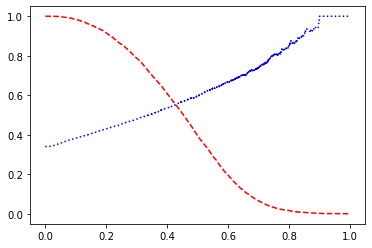

In [28]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)
plt.plot(thresholds, p[:-1], "b:")
plt.plot(thresholds, r[:-1], "r--")

## Model prediction on test set

0.6564088598402323
[[4702 2614]
 [1171 2529]]
Precision: 0.49173634065720395
Recall: 0.6835135135135135
f-score: 0.285988917788081


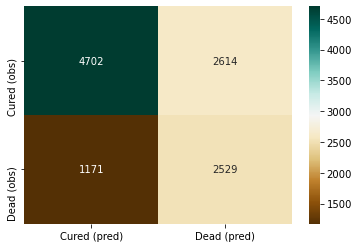

In [29]:
y_test_pred = res_ba1x.predict(sm.add_constant(X_test))
y_pred_1 = pd.DataFrame(y_test_pred)
y_test_df = pd.DataFrame(y_test)
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final= y_pred_final.rename(columns = {0 : 'Conversion_Prob'})
y_pred_final['final_predicted'] = y_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.35 else 0)
print(metrics.accuracy_score(y_pred_final['outcome'], y_pred_final.final_predicted))
confusion3 = metrics.confusion_matrix(y_pred_final['outcome'], y_pred_final.final_predicted )
print(confusion3)
df_cm = pd.DataFrame(confusion3,index=['Cured (obs)','Dead (obs)'],columns=['Cured (pred)','Dead (pred)'])
sns.heatmap(df_cm,annot=True,fmt='4d',cmap='BrBG')
TP = confusion3[1,1] 
TN = confusion3[0,0] 
FP = confusion3[0,1] 
FN = confusion3[1,0] 
#precision
print('Precision:',TP/(TP+FP))
#recall
print('Recall:',TP/(TP+FN))
#f-score
print('f-score:',((TP/(TP+FP))*(TP/(TP+FN)))/((TP/(TP+FP))+(TP/(TP+FN))))

# BA.2.X

## Fit and model evaluation

[[4215  141]
 [1080  143]]
0.7811435741172253
Precision: 0.5035211267605634
Recall: 0.1169255928045789
f-score: 0.0948905109489051


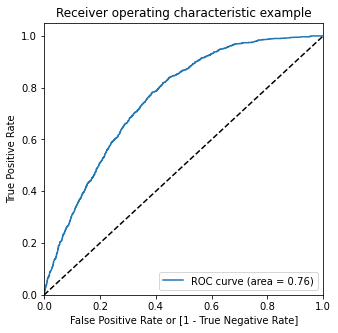

      prob  accuracy     sensi     speci
0.00  0.00  0.219215  1.000000  0.000000
0.05  0.05  0.380176  0.986100  0.210055
0.10  0.10  0.488439  0.950940  0.358586
0.15  0.15  0.570174  0.874080  0.484848
0.20  0.20  0.635060  0.798855  0.589073
0.25  0.25  0.686324  0.690924  0.685032
0.30  0.30  0.727729  0.555192  0.776171
0.35  0.35  0.754616  0.415372  0.849862
0.40  0.40  0.771106  0.293540  0.905188
0.45  0.45  0.780964  0.200327  0.943985
0.50  0.50  0.781144  0.116926  0.967631
0.55  0.55  0.783115  0.075225  0.981864
0.60  0.60  0.783115  0.040065  0.991736
0.65  0.65  0.783474  0.028618  0.995409
0.70  0.70  0.782578  0.017989  0.997245
0.75  0.75  0.781681  0.008994  0.998623
0.80  0.80  0.780606  0.003271  0.998852
0.85  0.85  0.780964  0.000818  1.000000
0.90  0.90  0.780785  0.000000  1.000000
0.95  0.95  0.780785  0.000000  1.000000
1.00  1.00  0.780785  0.000000  1.000000


<AxesSubplot:xlabel='prob'>

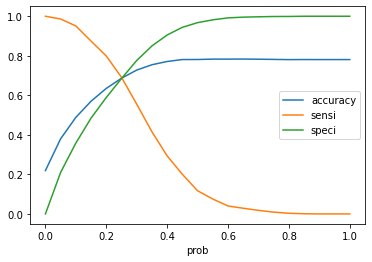

In [30]:
for variant in ['BA.2.X']:
    df_variant = df_encoded[df_encoded['variant_'+variant]==1].drop(columns=['age_group','ventilation_invasive','icu_adm','pregnancy','puerperal','ventilation_noninvasive','length_stay']).drop(columns=variant_list)
    param_variant = list_features[variants_name.index(variant)].copy()
    param_variant.append('outcome')
    df_variant = df_variant[param_variant]
    df_variant_filled = df_variant.dropna(axis=0)
    X, y = df_variant_filled.drop(['outcome'],1), df_variant_filled.outcome
    param_toscale = []
    for param in list_param_toscale:
        if param in df_variant_filled.columns:
                param_toscale.append(param)
    if len(param_toscale)>0:
        scaler = MinMaxScaler()
        X[param_toscale] = scaler.fit_transform(X[param_toscale])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
y_train_pred = res_ba2x.predict(sm.add_constant(X_train))
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final['Predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x>0.5 else 0)
#confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted)
print(confusion)
print(metrics.accuracy_score(y_train_pred_final.Converted,y_train_pred_final.Predicted))
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]
#precision
print('Precision:',TP/(TP+FP))
#recall
print('Recall:',TP/(TP+FN))
#f-score
print('f-score:',((TP/(TP+FP))*(TP/(TP+FN)))/((TP/(TP+FP))+(TP/(TP+FN))))
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)
numbers = [float(x)/10 for x in range(10)]
numbers = np.linspace(0,1,21)
for i in numbers:
    y_train_pred_final['%.2f'%i]= y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
num = np.linspace(0,1,21)
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final['%.2f'%i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

[[2984 1372]
 [ 378  845]]


<AxesSubplot:>

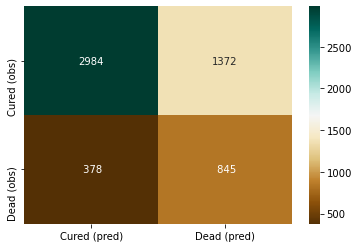

In [31]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map( lambda x: 1 if x > 0.25 else 0)
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
print(confusion2)
df_cm = pd.DataFrame(confusion2,index=['Cured (obs)','Dead (obs)'],columns=['Cured (pred)','Dead (pred)'])
sns.heatmap(df_cm,annot=True,fmt='4d',cmap='BrBG')

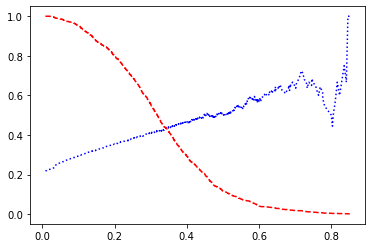

In [32]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)
plt.plot(thresholds, p[:-1], "b:")
plt.plot(thresholds, r[:-1], "r--")

## Model prediction on test set

0.7015050167224081
[[1333  546]
 [ 168  345]]
Precision: 0.3872053872053872
Recall: 0.672514619883041
f-score: 0.24572649572649577


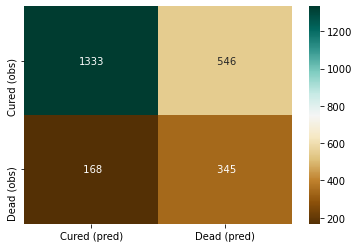

In [33]:
y_test_pred = res_ba2x.predict(sm.add_constant(X_test))
y_pred_1 = pd.DataFrame(y_test_pred)
y_test_df = pd.DataFrame(y_test)
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final= y_pred_final.rename(columns = {0 : 'Conversion_Prob'})
y_pred_final['final_predicted'] = y_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.25 else 0)
print(metrics.accuracy_score(y_pred_final['outcome'], y_pred_final.final_predicted))
confusion3 = metrics.confusion_matrix(y_pred_final['outcome'], y_pred_final.final_predicted )
print(confusion3)
df_cm = pd.DataFrame(confusion3,index=['Cured (obs)','Dead (obs)'],columns=['Cured (pred)','Dead (pred)'])
sns.heatmap(df_cm,annot=True,fmt='4d',cmap='BrBG')
TP = confusion3[1,1] 
TN = confusion3[0,0] 
FP = confusion3[0,1] 
FN = confusion3[1,0] 
#precision
print('Precision:',TP/(TP+FP))
#recall
print('Recall:',TP/(TP+FN))
#f-score
print('f-score:',((TP/(TP+FP))*(TP/(TP+FN)))/((TP/(TP+FP))+(TP/(TP+FN))))

# BA.4/5.X

## Fit and model evaluation

[[3987  271]
 [1041  368]]
0.7684842068113641
Precision: 0.5758998435054773
Recall: 0.26117814052519517
f-score: 0.1796875


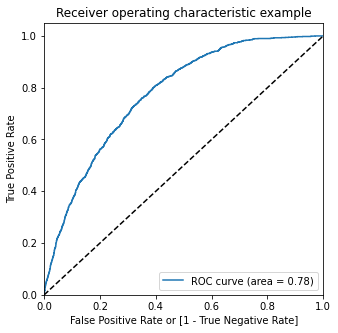

      prob  accuracy     sensi     speci
0.00  0.00  0.248632  1.000000  0.000000
0.05  0.05  0.386977  0.990774  0.187177
0.10  0.10  0.500971  0.958836  0.349460
0.15  0.15  0.575790  0.901348  0.468060
0.20  0.20  0.637551  0.826118  0.575153
0.25  0.25  0.684136  0.740951  0.665336
0.30  0.30  0.711840  0.647977  0.732973
0.35  0.35  0.741309  0.552874  0.803664
0.40  0.40  0.759661  0.446416  0.863316
0.45  0.45  0.768484  0.349894  0.906999
0.50  0.50  0.768484  0.261178  0.936355
0.55  0.55  0.767073  0.180270  0.961249
0.60  0.60  0.763014  0.117104  0.976750
0.65  0.65  0.758955  0.071682  0.986379
0.70  0.70  0.757720  0.043293  0.994129
0.75  0.75  0.755426  0.025550  0.996947
0.80  0.80  0.753838  0.013485  0.998826
0.85  0.85  0.752250  0.004258  0.999765
0.90  0.90  0.751720  0.001419  1.000000
0.95  0.95  0.751368  0.000000  1.000000
1.00  1.00  0.751368  0.000000  1.000000


<AxesSubplot:xlabel='prob'>

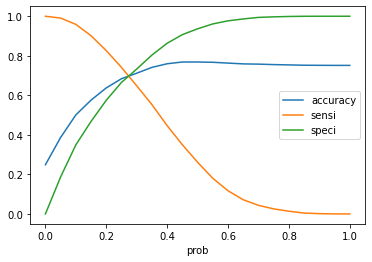

In [34]:
for variant in ['BA.4/5.X']:
    df_variant = df_encoded[df_encoded['variant_'+variant]==1].drop(columns=['age_group','ventilation_invasive','icu_adm','pregnancy','puerperal','ventilation_noninvasive','length_stay']).drop(columns=variant_list)
    param_variant = list_features[variants_name.index(variant)].copy()
    param_variant.append('outcome')
    df_variant = df_variant[param_variant]
    df_variant_filled = df_variant.dropna(axis=0)
    X, y = df_variant_filled.drop(['outcome'],1), df_variant_filled.outcome
    param_toscale = []
    for param in list_param_toscale:
        if param in df_variant_filled.columns:
                param_toscale.append(param)
    if len(param_toscale)>0:
        scaler = MinMaxScaler()
        X[param_toscale] = scaler.fit_transform(X[param_toscale])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
y_train_pred = res_ba45x.predict(sm.add_constant(X_train))
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final['Predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x>0.5 else 0)
#confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted)
print(confusion)
print(metrics.accuracy_score(y_train_pred_final.Converted,y_train_pred_final.Predicted))
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]
#precision
print('Precision:',TP/(TP+FP))
#recall
print('Recall:',TP/(TP+FN))
#f-score
print('f-score:',((TP/(TP+FP))*(TP/(TP+FN)))/((TP/(TP+FP))+(TP/(TP+FN))))
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)
numbers = [float(x)/10 for x in range(10)]
numbers = np.linspace(0,1,21)
for i in numbers:
    y_train_pred_final['%.2f'%i]= y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
num = np.linspace(0,1,21)
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final['%.2f'%i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

[[2982 1276]
 [ 429  980]]


<AxesSubplot:>

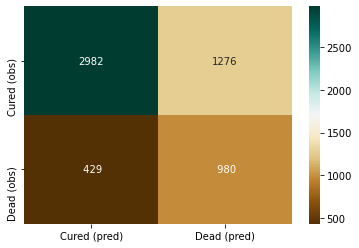

In [35]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map( lambda x: 1 if x > 0.275 else 0)
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
print(confusion2)
df_cm = pd.DataFrame(confusion2,index=['Cured (obs)','Dead (obs)'],columns=['Cured (pred)','Dead (pred)'])
sns.heatmap(df_cm,annot=True,fmt='4d',cmap='BrBG')

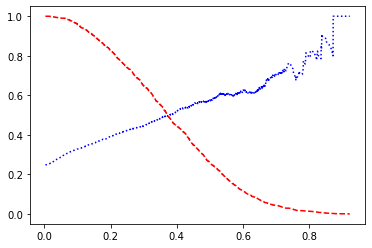

In [36]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)
plt.plot(thresholds, p[:-1], "b:")
plt.plot(thresholds, r[:-1], "r--")

## Model prediction on test set

0.6685878962536023
[[1161  626]
 [ 179  463]]
Precision: 0.4251606978879706
Recall: 0.721183800623053
f-score: 0.267475447718082


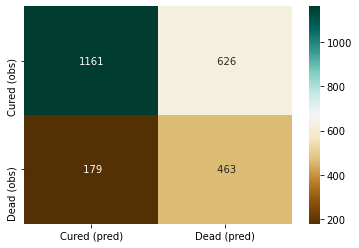

In [37]:
y_test_pred = res_ba45x.predict(sm.add_constant(X_test))
y_pred_1 = pd.DataFrame(y_test_pred)
y_test_df = pd.DataFrame(y_test)
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final= y_pred_final.rename(columns = {0 : 'Conversion_Prob'})
y_pred_final['final_predicted'] = y_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.25 else 0)
print(metrics.accuracy_score(y_pred_final['outcome'], y_pred_final.final_predicted))
confusion3 = metrics.confusion_matrix(y_pred_final['outcome'], y_pred_final.final_predicted )
print(confusion3)
df_cm = pd.DataFrame(confusion3,index=['Cured (obs)','Dead (obs)'],columns=['Cured (pred)','Dead (pred)'])
sns.heatmap(df_cm,annot=True,fmt='4d',cmap='BrBG')
TP = confusion3[1,1] 
TN = confusion3[0,0] 
FP = confusion3[0,1] 
FN = confusion3[1,0] 
#precision
print('Precision:',TP/(TP+FP))
#recall
print('Recall:',TP/(TP+FN))
#f-score
print('f-score:',((TP/(TP+FP))*(TP/(TP+FN)))/((TP/(TP+FP))+(TP/(TP+FN))))